In [29]:
import json
import pandas as pd
import re
import nltk
import tensorflow as tf
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
file_path = './Data/all_data_resep.csv'
data = pd.read_csv(file_path)

# Gabungkan kolom-kolom yang relevan 
data['Combined_Text'] = data['Title'] + " " + data['Ingredients'] + " " + data['Steps']

# Tambahkan threshold untuk kolom 'Loves'
threshold = 100
data['Label'] = (data['Loves'] >= threshold).astype(int)

In [30]:
# Bersihkan teks
nltk.download('wordnet')
nltk.download('stopwords')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split("--")
    stop_words = set(stopwords.words('indonesian'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

data['Ingredients'].apply(clean_text)
data['Steps'].apply(clean_text)
data['Cleaned_Text'] = data['Combined_Text'].apply(clean_text)

[nltk_data] Downloading package wordnet to C:\Users\Santi
[nltk_data]     Susanti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Santi
[nltk_data]     Susanti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# Menghapus emoji 
def clean_emoji(text):
  if text is not None and isinstance(text, str):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

for col in ['Ingredients', 'Title', 'Steps']:
    data[col] = data[col].fillna('').apply(clean_emoji)
data.head(1)

,Title,Ingredients,Steps,Loves,URL,Combined_Text,Label,Cleaned_Text
0,Ayam Woku Manado,1 Ekor Ayam Kampung (potong 12)--2 Buah Jeruk ...,Cuci bersih ayam dan tiriskan. Lalu peras jeru...,1,/id/resep/4473027-ayam-woku-manado,Ayam Woku Manado 1 Ekor Ayam Kampung (potong 1...,0,ayam woku manado ekor ayam kampung potong bu...


In [32]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Cleaned_Text'])

tfidf_tensor = tf.convert_to_tensor(tfidf_matrix.toarray(), dtype=tf.float32)

In [33]:
# Tokenisasi data teks yang sudah dibersihkan
data['Tokenized_Text'] = data['Cleaned_Text'].apply(lambda x: x.split())

word2vec_model = Word2Vec(
    sentences=data['Tokenized_Text'], 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4, 
    sg=1
)

# Simpan model untuk digunakan kembali
# word2vec_model.save("word2vec_resep.model")

In [34]:
# Fungsi untuk menghitung rata-rata embedding sebuah dokumen
def document_embedding(text, model, vector_size=100):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

data['Embedding'] = data['Cleaned_Text'].apply(
    lambda x: document_embedding(x, word2vec_model, vector_size=100)
)


In [35]:
data.head()

,Title,Ingredients,Steps,Loves,URL,Combined_Text,Label,Cleaned_Text,Tokenized_Text,Embedding
0,Ayam Woku Manado,1 Ekor Ayam Kampung (potong 12)--2 Buah Jeruk ...,Cuci bersih ayam dan tiriskan. Lalu peras jeru...,1,/id/resep/4473027-ayam-woku-manado,Ayam Woku Manado 1 Ekor Ayam Kampung (potong 1...,0,ayam woku manado ekor ayam kampung potong bu...,"[ayam, woku, manado, ekor, ayam, kampung, poto...","[0.1791115, 0.4670421, 0.08311139, -0.01860823..."
1,Ayam goreng tulang lunak,1 kg ayam (dipotong sesuai selera jangan kecil...,"Haluskan bumbu2nya (BaPut, ketumbar, kemiri, k...",1,/id/resep/4471956-ayam-goreng-tulang-lunak,Ayam goreng tulang lunak 1 kg ayam (dipotong s...,0,ayam goreng tulang lunak kg ayam dipotong ses...,"[ayam, goreng, tulang, lunak, kg, ayam, dipoto...","[0.113204196, 0.56125873, 0.08893835, 0.090403..."
2,Ayam cabai kawin,1/4 kg ayam--3 buah cabai hijau besar--7 buah ...,Panaskan minyak di dalam wajan. Setelah minyak...,2,/id/resep/4473057-ayam-cabai-kawin,Ayam cabai kawin 1/4 kg ayam--3 buah cabai hij...,0,ayam cabai kawin kg ayam buah cabai hijau bes...,"[ayam, cabai, kawin, kg, ayam, buah, cabai, hi...","[0.19361943, 0.52035785, 0.092416, 0.0583066, ..."
3,Ayam Geprek,250 gr daging ayam (saya pakai fillet)--Secuku...,Goreng ayam seperti ayam krispi--Ulek semua ba...,10,/id/resep/4473023-ayam-geprek,Ayam Geprek 250 gr daging ayam (saya pakai fil...,0,ayam geprek gr daging ayam saya pakai fillets...,"[ayam, geprek, gr, daging, ayam, saya, pakai, ...","[0.1353549, 0.48473006, 0.051493194, -0.017972..."
4,Minyak Ayam,400 gr kulit ayam & lemaknya--8 siung bawang p...,Cuci bersih kulit ayam. Sisihkan--Ambil 50 ml ...,4,/id/resep/4427438-minyak-ayam,Minyak Ayam 400 gr kulit ayam & lemaknya--8 si...,0,minyak ayam gr kulit ayam lemaknya siung baw...,"[minyak, ayam, gr, kulit, ayam, lemaknya, siun...","[0.17937896, 0.47707525, 0.021650854, 0.062491..."


In [36]:
# Pembagian data
X = data['Cleaned_Text']  
y = data['Label']        

# Membagi data menjadi training dan testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Menggunakan TF-IDF untuk representasi teks
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_matrix_val = tfidf_vectorizer.transform(X_val)

# Ubah ke TensorFlow tensor
X_train_tensor = tf.convert_to_tensor(tfidf_matrix_train.toarray(), dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(tfidf_matrix_val.toarray(), dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)  
y_val_tensor = tf.convert_to_tensor(y_val.values, dtype=tf.float32)  

In [37]:
# Model Neural Network dengan Regularization, Dropout, dan Learning Rate Scheduler
def create_model(input_shape):
    model = models.Sequential()
    
    # Layer pertama (Dense dengan L2 Regularization dan Dropout)
    model.add(layers.Dense(512, activation='relu', input_shape=input_shape,
                           kernel_regularizer=regularizers.l2(0.01)))  
    model.add(layers.Dropout(0.5))  
    
    # Layer kedua
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    # Layer output
    model.add(layers.Dense(1, activation='sigmoid')) 
    
    # Kompilasi model dengan optimizer dan loss function
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = create_model((X_train_tensor.shape[1],))  

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)


C:\Users\Santi Susanti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# Melatih model
history = model.fit(
    X_train_tensor,  
    y_train_tensor,  
    epochs=10, 
    batch_size=32, 
    validation_data=(X_val_tensor, y_val_tensor),  
    callbacks=[early_stopping, lr_scheduler]  
)

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9777 - loss: 1.9792 - val_accuracy: 0.9904 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9918 - loss: 0.0594 - val_accuracy: 0.9904 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9898 - loss: 0.0656 - val_accuracy: 0.9904 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9903 - loss: 0.0620 - val_accuracy: 0.9904 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9905 - loss: 0.0589 - val_accuracy: 0.9904 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9902 - loss: 0.0596 - val_accuracy: 0.9904 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9902 - loss: 0.

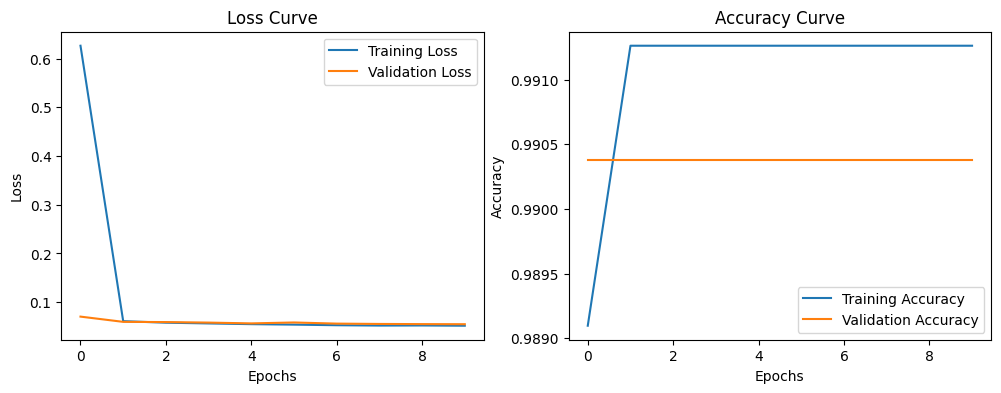

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0446
Validation Loss: 0.05488021299242973
Validation Accuracy: 0.9903815388679504


In [39]:
# Menampilkan hasil pelatihan
import matplotlib.pyplot as plt

# Ploting loss dan accuracy
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(X_val_tensor, y_val_tensor)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

In [40]:
def recommend_recipes(query, tfidf_tensor, tfidf_vectorizer, data, top_n=10):
    # Preprocess query
    query_cleaned = clean_text(query)
    query_vector = tfidf_vectorizer.transform([query_cleaned]).toarray()
    query_tensor = tf.convert_to_tensor(query_vector, dtype=tf.float32)

    # Hitung cosine similarity
    query_norm = tf.linalg.norm(query_tensor, axis=1)
    tfidf_norm = tf.linalg.norm(tfidf_tensor, axis=1)
    dot_product = tf.matmul(query_tensor, tf.transpose(tfidf_tensor))
    similarities = dot_product / (query_norm * tfidf_norm)

    # Mendapatkan top N rekomendasi
    similarities = tf.squeeze(similarities).numpy()
    top_indices = similarities.argsort()[-top_n:][::-1]
    recommended_recipes = data.iloc[top_indices]

    # Convert hasil ke JSON format serializable 
    recommendations_json = recommended_recipes[['Title', 'Ingredients', 'Steps', 'Loves']].to_dict(orient='records')
    
    return recommendations_json

# Contoh query
query = "sapi"
recommended_recipes_json = recommend_recipes(query, tfidf_tensor, tfidf_vectorizer, data, top_n=10)

# Simpan hasil rekomendasi dalam format JSON
with open('recommended_recipes.json', 'w') as json_file:
    json.dump(recommended_recipes_json, json_file, indent=4)

# Output JSON sebagai contoh
print(json.dumps(recommended_recipes_json, indent=4))

[
    {
        "Title": "Sapi Sambal Pete",
        "Ingredients": "250 gr daging sapi has dalam--Kaldu sapi rebusan--1 papan pete--2 sdt saus tiram--Lada hitam--secukupnya Minyak wijen--secukupnya Kecap manis--secukupnya Kecap ikan--secukupnya Minyak goreng--Bumbu halus: (diblender)--5 cabe keriting--2 cabe merah--2 cm jahe--6 siung bawang merah--6 siung bawang putih--1 sdt bubuk jinten--secukupnya Air putih--secukupnya Gula--secukupnya Garam--secukupnya Penyedap rasa sapi--",
        "Steps": "Rebus daging sapi yg sudah dipotong-potong. Kaldunya jangan dibuang untuk diolah.--Blender bumbu halus.--Tumis bumbu halus hingga harum.--Masukkan daging sapi yg telah direbus, kaldu sapi, dan pete.--Aduk hingga matang.--",
        "Loves": 6
    },
    {
        "Title": "Semur Lidah Sapi",
        "Ingredients": "500 gr Lidah sapi--Secukupnya air kaldu rebusan lidah sapi--1 buah tomat, iris--40 ml kecap manis, sesuaikan selera--sedikit pala/ bubuk pala--sesuai selera bawang goreng-- Bumbu ha

In [41]:
# !pip install tensorflowjs

In [42]:
# Save Model ke h5
model.save('feat-search-2.h5')

In [43]:
# # Convert to tensorflowjs
# tensorflowjs_converter --input_format keras model_recipes.h5 tfjs_model/

In [44]:
# from flask import Flask, request, jsonify

# app = Flask(__name__)

# # Endpoint untuk mendapatkan rekomendasi
# @app.route('/recommend', methods=['POST'])
# def recommend():
#     query = request.json.get('query', '')
#     top_n = int(request.json.get('top_n', 5))
#     recommendations = recommend_recipes(query, data, word2vec_model, top_n)
#     response = recommendations[['Title', 'Ingredients', 'Steps', 'Loves']].to_dict(orient='records')
#     return jsonify(response)

# if __name__ == '__main__':
#     app.run(debug=True)
